In [175]:
import numpy as np
import glob
import pandas as pd
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize

import tensorflow as tf
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense


## Reshape the keypoints data

In [2]:
datapath = "../keypoints/"

In [98]:
kp_files = glob.glob(datapath + '*.txt')

In [4]:
# Get labels from file names
labels = [int(x.split('_')[0].split("/")[-1]) for x in kp_files]

In [99]:
# read in text files
len(labels)

259

In [210]:
# '''
# Note --- arrays are clipped at 440, because there's some variation around the dimension that is ~450
# '''

features = []
count = 1

for file in kp_files:
    print(count, end=" ")
    count += 1

    data = pd.read_csv(file, sep="\t", header=None)
    data.columns = ["time", "kpoints", "count", "fps"]
    data.kpoints = data.kpoints.apply(lambda x: ast.literal_eval(x.strip("()")))
    times = [t-data.time[0] for t in data.time[0:440]]

    #Select upper body keypoints
    kp_ind = [0, 1, 2, 3, 4, 5, 6, 17]

    # matrix dims: time, kp, (kp_num, x, y)
    kp_mat = np.array(data.kpoints.tolist(), dtype=float)[0:440, kp_ind,:]

    kp_y = kp_mat[0:440, :,2]

    # R ear to R shoulder, L ear to L shoulder, nose to neck
    distances = [(2,6), (1,5), (0,7)]

    d_arr = []

    for tup in distances:
        p1x = kp_mat[:, tup[0], 1]
        p1y = kp_mat[:, tup[0], 2]
        p2x = kp_mat[:, tup[1], 1]
        p2y = kp_mat[:, tup[1], 2]

        dist = ((p1x-p2x)**2 + (p1y-p2y)**2)**.5    
        d_arr.append(dist)

    d_mat = np.array(d_arr).T

    t_mat = np.array(times).reshape(440, 1)

    full_mat = np.hstack((t_mat, kp_y, d_mat)).reshape(440, 12, 1)

    features.append(full_mat)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 

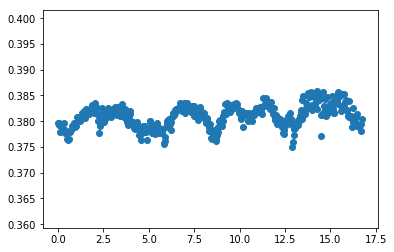

In [202]:
# Check keypoint movement over time
plt.scatter(t_mat, d_mat[:, 1])

## Write/read the data

In [302]:
# Save data

import pickle
# pickle.dump(features, open("features.txt", "wb"))
# pickle.dump(labels, open("labels.txt", "wb"))

In [122]:
# Read data
features = pickle.load(open("features.txt", "rb"))
labels = pickle.load(open("labels.txt", "rb"))

In [211]:
X = np.array(features)
print(X.shape)

(259, 440, 12, 1)


In [212]:
Y = np.array(labels)
print(Y.shape)

(259,)


In [213]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=24601)

In [214]:
X_train.shape

(220, 440, 12, 1)

In [268]:
# normalize

train_mean = np.nanmean(X_train[:, :, 1:, :], axis=0)
train_std = np.nanstd(X_train[:, :, 1:, :], axis=0)

train_mean = np.hstack((np.zeros((440, 1, 1)), train_mean))
train_std = np.hstack((np.ones((440, 1, 1)), train_std))

train_mean.shape

X_train_sc = np.nan_to_num((X_train - train_mean)/train_std)

X_test_sc = np.nan_to_num((X_test - train_mean)/train_std)

(440, 12, 1)